In [1]:
import os 
from pathlib import Path
import sys
import subprocess
import time
from typing import Optional
from collections import defaultdict 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

executables = ['genmc-wkmo', 'genmc-xmm']
arguments_dict = {
    'genmc-xmm' : ['--v0', '--disable-ipr', '--disable-sr', '--XMM'],
    'genmc-wkmo' : ['--count-duplicate-execs', '--wkmo'],
}
tests = sorted([Path('tests') / t / 'variants' / v for t in os.listdir('tests') if os.path.isdir(Path('tests') / t) for v in os.listdir(Path('tests') / t / 'variants')])
test_names = sorted([t for t in os.listdir('tests') if os.path.isdir(Path('tests') / t) for v in os.listdir(Path('tests') / t / 'variants')])
subprocess_timeout = 1 #s

class RunExecutableResult:
    class Timeout:
        pass
    class Ok:
        def __init__(self, output) -> None:
            super().__init__()
            self.output = output
    class Error:
        def __init__(self, retcode, output) -> None:
            super().__init__()
            self.retcode = retcode
            self.output = output

def run_executable(exe_path: Path, args: list[str], test_path: Path) -> RunExecutableResult:
    try:
        result = subprocess.run([exe_path, *args, test_path], stdout=subprocess.PIPE, stderr=subprocess.PIPE, timeout=subprocess_timeout)
        result_stdout = result.stdout.decode()
        result_stderr = result.stderr.decode()
        if result.returncode == 0:
            return RunExecutableResult.Ok(result_stdout + result_stderr)
        else:
            return RunExecutableResult.Error(result.returncode, result_stdout + result_stderr)
    except subprocess.TimeoutExpired:
        return RunExecutableResult.Timeout()

In [2]:
def get_duplicate_executions(string: str) -> Optional[int]:
    pattern = "Number of duplicate executions explored: "
    i = string.index(pattern) + len(pattern)
    number_str = ""
    while i < len(string) and string[i].isdigit():
        number_str += string[i]
        i += 1
    try:
        return int(number_str)
    except:
        return None

assert(get_duplicate_executions("abc 123 Number of duplicate executions explored: 123456") == 123456)

def get_number_executions(string: str) -> Optional[int]:
    pattern = "Number of complete executions explored: "
    i = string.index(pattern) + len(pattern)
    number_str = ""
    while i < len(string) and string[i].isdigit():
        number_str += string[i]
        i += 1
    try:
        return int(number_str)
    except:
        return None

assert(get_number_executions("abc 123 Number of complete executions explored: 123456") == 123456)

In [3]:
class ResultItem:
    def __init__(self, execs, dups) -> None:
        self.execs = execs
        self.dups = dups

def run_and_get_results(exe_path: Path, args: list[str], test_path: Path) -> RunExecutableResult:
    res = run_executable(exe_path, args, test_path)
    if isinstance(res, RunExecutableResult.Ok):
        execs = get_number_executions(res.output)
        dups = get_duplicate_executions(res.output)
        if execs is None:
            print(f"could not get number of executions in {res.output}")
            return RunExecutableResult.Ok(0)
        if dups is None:
            print(f"could not get duplicate executions in {res.output}")
            return RunExecutableResult.Ok(0)
        return RunExecutableResult.Ok(ResultItem(execs, dups))
    else:
        return res

In [4]:
results = defaultdict(lambda: [])

for exe in executables:
    for test in tests:
        r = run_and_get_results(Path("executables") / exe, arguments_dict[exe], test)
        assert(isinstance(r, RunExecutableResult.Ok))
        results[exe].append(r.output)

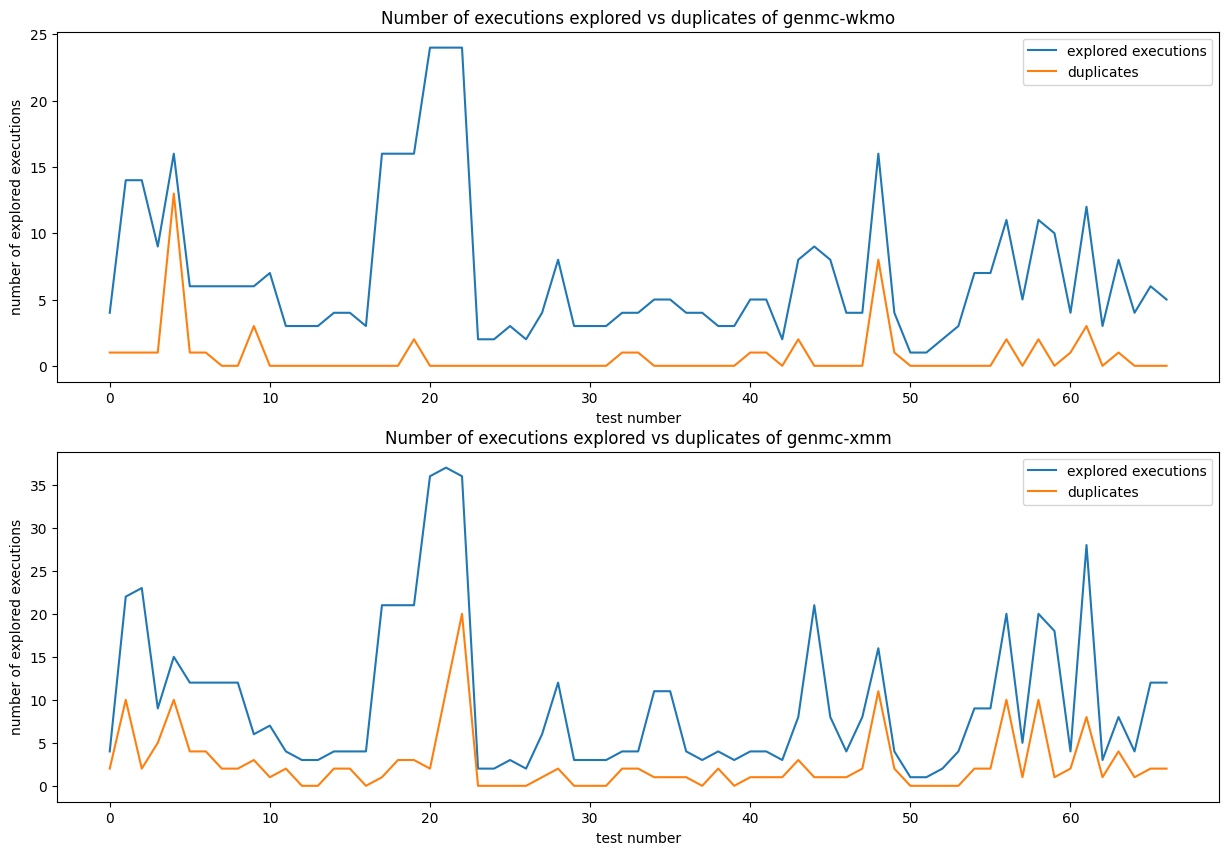

In [5]:
plt.figure(figsize=(15, 10))
for index, exe in enumerate(executables):
    plt.subplot(2, 1, index + 1)  # (rows, columns, subplot index)
    plt.plot([r.execs for r in results[exe]])
    plt.plot([r.dups for r in results[exe]])
    plt.legend(["explored executions", "duplicates"])
    plt.xlabel("test number")
    plt.ylabel("number of explored executions")
    plt.title(f"Number of executions explored vs duplicates of {exe}")
plt.show()

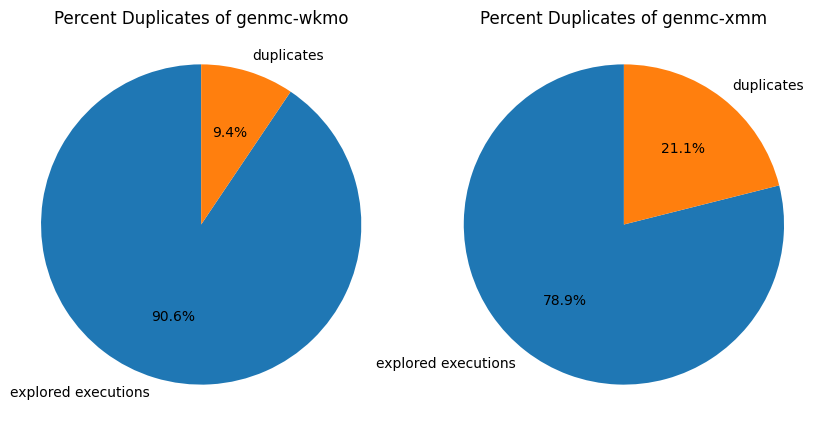

In [6]:

plt.figure(figsize=(10, 5))

for i, exe in enumerate(executables):
    execs = np.sum([r.execs for r in results[exe]])
    dups = np.sum([r.dups for r in results[exe]])

    plt.subplot(1, 2, i+1)
    plt.pie([execs, dups], labels=["explored executions", "duplicates"], autopct='%1.1f%%', startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title(f'Percent Duplicates of {exe}')
plt.show()


In [7]:
def bar_plot(values):
    labels = executables

    # Creating the bar plot
    plt.bar(labels, values, color=['blue', 'darkorange'])

    # Adding titles and labels
    plt.title('Number of executions over all tests')
    plt.ylabel('Total number of executions')

    # Show the plot
    plt.show()


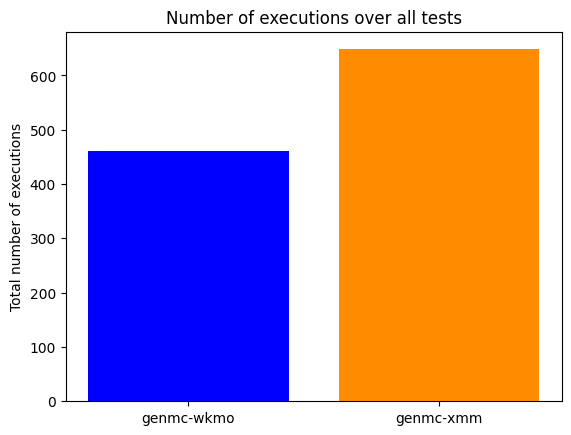

genmc-xmm had 40.56% more values than genmc-wkmo


In [8]:
# Values for the bar plot
values = [np.sum([r.execs for r in results[exe]]) for exe in executables]
bar_plot(values)
norm_values = [v / min(values) for v in values]
assert(executables[1] == "genmc-xmm")
assert(executables[0] == "genmc-wkmo")
diff_norm_values = (norm_values[1] - norm_values[0]) * 100
print(f"{executables[1]} had {diff_norm_values:.2f}% more values than {executables[0]}")


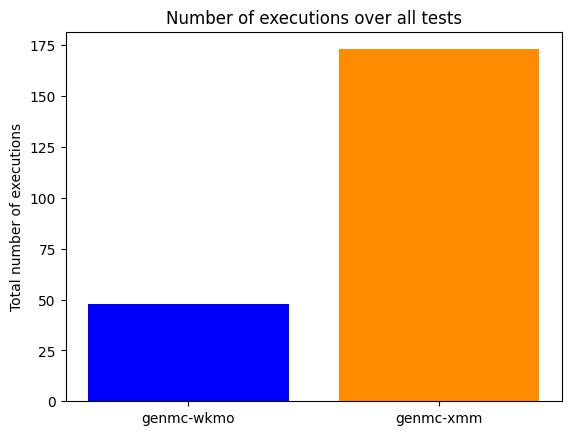

genmc-xmm had 260.42% more duplicates than genmc-wkmo


In [9]:
values = [np.sum([r.dups for r in results[exe]]) for exe in executables]
bar_plot(values)
norm_values = [v / min(values) for v in values]
assert(executables[1] == "genmc-xmm")
assert(executables[0] == "genmc-wkmo")
diff_norm_values = (norm_values[1] - norm_values[0]) * 100
print(f"{executables[1]} had {diff_norm_values:.2f}% more duplicates than {executables[0]}")
